In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d

Equation:

$$
0 = \max_{e} \min_{h_2} b\left[\delta \eta \log e - \tau(\delta+\rho)y -\frac{\gamma_2}{2}\beta_f^2y^2\right] -\ell e + \frac{\partial \phi}{\partial y}(y, b;\ell) e - \frac{\partial \phi}{\partial b}(y, b;\ell) \delta b
$$

FOC of $e$ gives :

$$
e^* = \frac{b \delta \eta}{\ell - \frac{\partial \phi}{\partial y}(y, b; \ell)}
$$

In [52]:
def false_transient_one_iteration(stateSpace, A, B_b, B_y, C_bb, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_b.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_bb.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(b_grid, y_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras
    γ_2 = 2*0.0022
    β_f = 1.86/1000
    
    Δ_b = b_grid[1] - b_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (b_mat, y_mat) = np.meshgrid(b_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([b_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(b_mat)
#         v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_db = compute_derivatives_2d(v0, 0, 1, Δ_b)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = b_mat*δ*η / (ℓ-v0_dy)
#         e[e<=0] = 1e-5

        A = np.zeros_like(b_mat)
        B_b = -(δ*b_mat)
        B_y = e
        C_bb = np.zeros_like(b_mat)
        C_yy = np.zeros_like(b_mat)
        D = b_mat*(δ*η*np.log(e) - τ*(δ+ρ)*y_mat - y_mat**2/2*β_f**2*γ_2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_b, B_y, C_bb, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = B_b*v0_db + B_y*v0_dy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
#         error = rhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0

In [53]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

# Grid setting
n_b = 200
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

n_y = 200
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

# ℓ setting
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [25]:
# ψs = []
# ψs_next = []

# for i, ℓ in enumerate(np.exp(log_ell_grid)):
#     print(i)
#     max_iter = 1000
#     \ell
#     ψ = false_transient(z_grid, b_grid, y_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψ_next = false_transient(z_grid, b_grid, y_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψs.append(ψ)
#     ψs_next.append(ψ_next)

In [55]:
ψ = false_transient(b_grid, y_grid, 1e-4, model_paras=model_paras, v0=None, ϵ=.3, tol=1e-8, max_iter=4_000)

Iteration 1: LHS Error: 0.11635356616438176; RHS Error 0.11664287174086219
Iteration 2: LHS Error: 0.11605089468558166; RHS Error 0.11634871886005
Iteration 3: LHS Error: 0.11574362286768003; RHS Error 0.11604740035432709
Iteration 4: LHS Error: 0.11543290522855937; RHS Error 0.1157409866928983
Iteration 5: LHS Error: 0.11511958485583859; RHS Error 0.11543084720532693
Iteration 6: LHS Error: 0.11480429061309352; RHS Error 0.11511793466493248
Iteration 7: LHS Error: 0.11448750179305986; RHS Error 0.11480293874067879
Iteration 8: LHS Error: 0.11416959101173066; RHS Error 0.1144863746461374
Iteration 9: LHS Error: 0.11385085309815765; RHS Error 0.1141686373499397
Iteration 10: LHS Error: 0.11353152499869087; RHS Error 0.11385003610743928
Iteration 11: LHS Error: 0.11321179976207944; RHS Error 0.11353081756147296
Iteration 12: LHS Error: 0.11289183658931576; RHS Error 0.11321118146883082
Iteration 13: LHS Error: 0.11257176818006864; RHS Error 0.11289129178796249
Iteration 14: LHS Error: 0.

Iteration 115: LHS Error: 0.0833953526677996; RHS Error 0.08364327563639687
Iteration 116: LHS Error: 0.08314814174085713; RHS Error 0.0833953454308271
Iteration 117: LHS Error: 0.08290164845863165; RHS Error 0.08314813465056757
Iteration 118: LHS Error: 0.0826558710328884; RHS Error 0.08290164151112273
Iteration 119: LHS Error: 0.0824108076721227; RHS Error 0.08265586422441266
Iteration 120: LHS Error: 0.08216645658179071; RHS Error 0.08241080099904022
Iteration 121: LHS Error: 0.0819228159645998; RHS Error 0.08216645004059099
Iteration 122: LHS Error: 0.08167988402076591; RHS Error 0.08192280955189252
Iteration 123: LHS Error: 0.0814376589482535; RHS Error 0.08167987773326282
Iteration 124: LHS Error: 0.08119613894301973; RHS Error 0.08143765278277756
Iteration 125: LHS Error: 0.08095532219923504; RHS Error 0.08119613289648953
Iteration 126: LHS Error: 0.08071520690952443; RHS Error 0.08095531626867306
Iteration 127: LHS Error: 0.08047579126518509; RHS Error 0.0807152010920579
Iterat

Iteration 226: LHS Error: 0.0599406286379504; RHS Error 0.060119470865788595
Iteration 227: LHS Error: 0.059762313702845425; RHS Error 0.05994062685178191
Iteration 228: LHS Error: 0.05958452633627154; RHS Error 0.05976231193634577
Iteration 229: LHS Error: 0.05940726501182899; RHS Error 0.05958452458913802
Iteration 230: LHS Error: 0.059230528207165165; RHS Error 0.05940726328383338
Iteration 231: LHS Error: 0.059054314403767336; RHS Error 0.05923052649799019
Iteration 232: LHS Error: 0.05887862208705445; RHS Error 0.05905431271314868
Iteration 233: LHS Error: 0.05870344974640378; RHS Error 0.05887862041475622
Iteration 234: LHS Error: 0.05852879587505615; RHS Error 0.05870344809216359
Iteration 235: LHS Error: 0.05835465897014854; RHS Error 0.05852879423861189
Iteration 236: LHS Error: 0.05818103753268152; RHS Error 0.05835465735123579
Iteration 237: LHS Error: 0.058007930067584354; RHS Error 0.0581810359310748
Iteration 238: LHS Error: 0.05783533508366172; RHS Error 0.05800792848304

Iteration 336: LHS Error: 0.04318146187925957; RHS Error 0.04331045684068814
Iteration 337: LHS Error: 0.04305284955900805; RHS Error 0.04318146125097207
Iteration 338: LHS Error: 0.042924619383297724; RHS Error 0.043052848935897836
Iteration 339: LHS Error: 0.04279677022517525; RHS Error 0.042924618765289635
Iteration 340: LHS Error: 0.042669300960952825; RHS Error 0.042796769612223826
Iteration 341: LHS Error: 0.04254221047015191; RHS Error 0.04266930035300753
Iteration 342: LHS Error: 0.042415497635535836; RHS Error 0.04254220986716929
Iteration 343: LHS Error: 0.04228916134300913; RHS Error 0.04241549703744116
Iteration 344: LHS Error: 0.04216320048173294; RHS Error 0.04228916074976906
Iteration 345: LHS Error: 0.04203761394404223; RHS Error 0.042163199893301875
Iteration 346: LHS Error: 0.04191240062544862; RHS Error 0.04203761336037164
Iteration 347: LHS Error: 0.041787559424640484; RHS Error 0.04191240004648593
Iteration 348: LHS Error: 0.041663089243465144; RHS Error 0.04178755

Iteration 443: LHS Error: 0.03137922743632634; RHS Error 0.031473020398615076
Iteration 444: LHS Error: 0.03128571382190397; RHS Error 0.031379227643511004
Iteration 445: LHS Error: 0.031192478520776966; RHS Error 0.03128571402913567
Iteration 446: LHS Error: 0.03109952070804667; RHS Error 0.031192478728089904
Iteration 447: LHS Error: 0.031006839561117754; RHS Error 0.03109952091537327
Iteration 448: LHS Error: 0.03091443425985811; RHS Error 0.031006839768448785
Iteration 449: LHS Error: 0.030822303986598836; RHS Error 0.03091443446722171
Iteration 450: LHS Error: 0.03073044792595662; RHS Error 0.03082230419394387
Iteration 451: LHS Error: 0.03063886526504689; RHS Error 0.03073044813332801
Iteration 452: LHS Error: 0.030547555193318015; RHS Error 0.03063886547243061
Iteration 453: LHS Error: 0.030456516902521713; RHS Error 0.03054755540067354
Iteration 454: LHS Error: 0.030365749586837392; RHS Error 0.03045651710986598
Iteration 455: LHS Error: 0.03027525244272411; RHS Error 0.0303657

Iteration 553: LHS Error: 0.022596276838005025; RHS Error 0.022663840315785944
Iteration 554: LHS Error: 0.022528914801043243; RHS Error 0.022596277024322667
Iteration 555: LHS Error: 0.022461753419958562; RHS Error 0.022528914987025916
Iteration 556: LHS Error: 0.022394792098274035; RHS Error 0.022461753605638193
Iteration 557: LHS Error: 0.02232803024122395; RHS Error 0.022394792283631962
Iteration 558: LHS Error: 0.022261467255842625; RHS Error 0.022328030426252685
Iteration 559: LHS Error: 0.02219510255082824; RHS Error 0.022261467440515117
Iteration 560: LHS Error: 0.02212893553676191; RHS Error 0.022195102735193067
Iteration 561: LHS Error: 0.022062965625864926; RHS Error 0.02212893572079419
Iteration 562: LHS Error: 0.02199719223212308; RHS Error 0.022062965809560506
Iteration 563: LHS Error: 0.021931614771257085; RHS Error 0.02199719241549318
Iteration 564: LHS Error: 0.021866232660746242; RHS Error 0.021931614954310105
Iteration 565: LHS Error: 0.021801045319733703; RHS Error 

Iteration 662: LHS Error: 0.01631888229542374; RHS Error 0.016367686370120246
Iteration 663: LHS Error: 0.016270223813782774; RHS Error 0.016318882443576696
Iteration 664: LHS Error: 0.016221710343706047; RHS Error 0.016270223961574334
Iteration 665: LHS Error: 0.016173341453521083; RHS Error 0.016221710491146013
Iteration 666: LHS Error: 0.01612511671279293; RHS Error 0.016173341600589503
Iteration 667: LHS Error: 0.016077035692454444; RHS Error 0.01612511685952843
Iteration 668: LHS Error: 0.016029097964599025; RHS Error 0.016077035838823084
Iteration 669: LHS Error: 0.01598130310268194; RHS Error 0.01602909811062736
Iteration 670: LHS Error: 0.015933650681396; RHS Error 0.015981303248378445
Iteration 671: LHS Error: 0.01588614027666561; RHS Error 0.015933650826735854
Iteration 672: LHS Error: 0.015838771465706003; RHS Error 0.015886140421653067
Iteration 673: LHS Error: 0.015791543827011388; RHS Error 0.01583877161035986
Iteration 674: LHS Error: 0.01574445626342088; RHS Error 0.015

Iteration 770: LHS Error: 0.011819980874830568; RHS Error 0.01185533561569621
Iteration 771: LHS Error: 0.011784732036345485; RHS Error 0.011819981381423483
Iteration 772: LHS Error: 0.011749588278148575; RHS Error 0.01178473254155768
Iteration 773: LHS Error: 0.01171454928712734; RHS Error 0.01174958878201142
Iteration 774: LHS Error: 0.011679614750992329; RHS Error 0.01171454978960619
Iteration 775: LHS Error: 0.011644784358454768; RHS Error 0.01167961525208304
Iteration 776: LHS Error: 0.01161005779915551; RHS Error 0.011644784858173787
Iteration 777: LHS Error: 0.011575434763629508; RHS Error 0.011610058297512132
Iteration 778: LHS Error: 0.011540914943382793; RHS Error 0.011575435260644099
Iteration 779: LHS Error: 0.011506498030815493; RHS Error 0.011540915439053279
Iteration 780: LHS Error: 0.0114721837192396; RHS Error 0.011506498525128514
Iteration 781: LHS Error: 0.011437971702920418; RHS Error 0.011472184212221237
Iteration 782: LHS Error: 0.011403861676952214; RHS Error 0.0

Iteration 882: LHS Error: 0.008459367588589117; RHS Error 0.008484673048723287
Iteration 883: LHS Error: 0.008434137952519905; RHS Error 0.008459367959701272
Iteration 884: LHS Error: 0.008408983543427933; RHS Error 0.008434138322551674
Iteration 885: LHS Error: 0.008383904137148809; RHS Error 0.008408983912427406
Iteration 886: LHS Error: 0.008358899510151712; RHS Error 0.008383904505117376
Iteration 887: LHS Error: 0.008333969439527541; RHS Error 0.00835889987706094
Iteration 888: LHS Error: 0.008309113703071821; RHS Error 0.008333969805397815
Iteration 889: LHS Error: 0.008284332079243248; RHS Error 0.008309114067925116
Iteration 890: LHS Error: 0.008259624347175532; RHS Error 0.008284332443069128
Iteration 891: LHS Error: 0.008234990286547136; RHS Error 0.008259624709931343
Iteration 892: LHS Error: 0.008210429677877329; RHS Error 0.008234990648320895
Iteration 893: LHS Error: 0.00818594230217684; RHS Error 0.00821043003861173
Iteration 894: LHS Error: 0.0081615279411551; RHS Error

Iteration 986: LHS Error: 0.006200465813493613; RHS Error 0.0062190153844518675
Iteration 987: LHS Error: 0.006181971832296777; RHS Error 0.006200466089133161
Iteration 988: LHS Error: 0.006163532999578318; RHS Error 0.0061819721071536965
Iteration 989: LHS Error: 0.006145149150918646; RHS Error 0.006163533273616767
Iteration 990: LHS Error: 0.006126820122383711; RHS Error 0.0061451494241414745
Iteration 991: LHS Error: 0.00610854575059013; RHS Error 0.006126820394834101
Iteration 992: LHS Error: 0.006090325265812879; RHS Error 0.006108546022284653
Iteration 993: LHS Error: 0.006072159693673029; RHS Error 0.006090326252427905
Iteration 994: LHS Error: 0.006054048241382523; RHS Error 0.0060721606773385395
Iteration 995: LHS Error: 0.006035990791091924; RHS Error 0.00605404922209106
Iteration 996: LHS Error: 0.006017987202344699; RHS Error 0.006035991768856025
Iteration 997: LHS Error: 0.006000037322912988; RHS Error 0.00601798817721029
Iteration 998: LHS Error: 0.005982140994736559; RHS

Iteration 1093: LHS Error: 0.004504108017571914; RHS Error 0.004517584090680801
Iteration 1094: LHS Error: 0.004490672867045002; RHS Error 0.004504108748492011
Iteration 1095: LHS Error: 0.004477277786083533; RHS Error 0.004490673595800743
Iteration 1096: LHS Error: 0.0044639226551031665; RHS Error 0.004477278512679747
Iteration 1097: LHS Error: 0.0044506073549044345; RHS Error 0.004463923379557644
Iteration 1098: LHS Error: 0.004437331766643146; RHS Error 0.004450608077222334
Iteration 1099: LHS Error: 0.004424095771794849; RHS Error 0.0044373324868104275
Iteration 1100: LHS Error: 0.004410899252231815; RHS Error 0.004424096489832191
Iteration 1101: LHS Error: 0.004397742090163822; RHS Error 0.004410899968150084
Iteration 1102: LHS Error: 0.0043846241681381555; RHS Error 0.004397742803957355
Iteration 1103: LHS Error: 0.0043715453690929; RHS Error 0.0043846248798281445
Iteration 1104: LHS Error: 0.0043585055763036475; RHS Error 0.0043715460786887955
Iteration 1105: LHS Error: 0.004345

Iteration 1201: LHS Error: 0.0032620350311418633; RHS Error 0.0032717952625018615
Iteration 1202: LHS Error: 0.0032523044461107986; RHS Error 0.0032620355625739977
Iteration 1203: LHS Error: 0.003242602887721565; RHS Error 0.00325230497602029
Iteration 1204: LHS Error: 0.003232930269400451; RHS Error 0.003242603416063944
Iteration 1205: LHS Error: 0.0032232865049586223; RHS Error 0.0032329307962059017
Iteration 1206: LHS Error: 0.0032136715083671183; RHS Error 0.0032232870301996397
Iteration 1207: LHS Error: 0.0032040851939344845; RHS Error 0.003213672032079992
Iteration 1208: LHS Error: 0.003194527476164666; RHS Error 0.0032040857161022285
Iteration 1209: LHS Error: 0.0031849982698458255; RHS Error 0.00319452799679934
Iteration 1210: LHS Error: 0.003175497490044421; RHS Error 0.0031849987889641246
Iteration 1211: LHS Error: 0.0031660250519512565; RHS Error 0.003175498007602792
Iteration 1212: LHS Error: 0.003156580871213066; RHS Error 0.0031660255680384525
Iteration 1213: LHS Error: 0

Iteration 1308: LHS Error: 0.0023695533332516545; RHS Error 0.0023766428118851685
Iteration 1309: LHS Error: 0.0023624853970538595; RHS Error 0.002369553721784587
Iteration 1310: LHS Error: 0.002355438550557902; RHS Error 0.0023624857844537633
Iteration 1311: LHS Error: 0.0023484127309162757; RHS Error 0.002355438936834542
Iteration 1312: LHS Error: 0.0023414078754176635; RHS Error 0.0023484131160645128
Iteration 1313: LHS Error: 0.002334423921623123; RHS Error 0.0023414082594699626
Iteration 1314: LHS Error: 0.0023274608071884493; RHS Error 0.0023344243045586577
Iteration 1315: LHS Error: 0.0023205184700003656; RHS Error 0.002327461189005689
Iteration 1316: LHS Error: 0.002313596848135073; RHS Error 0.0023205188507068875
Iteration 1317: LHS Error: 0.002306695879834564; RHS Error 0.002313597227732403
Iteration 1318: LHS Error: 0.002299815503542154; RHS Error 0.0023066962583269124
Iteration 1319: LHS Error: 0.0022929556578669503; RHS Error 0.0022998158809165586
Iteration 1320: LHS Error

Iteration 1414: LHS Error: 0.0017264648369774704; RHS Error 0.0017316286131000141
Iteration 1415: LHS Error: 0.0017213161152440648; RHS Error 0.001726464474538586
Iteration 1416: LHS Error: 0.0017161827654632589; RHS Error 0.0017213157539502505
Iteration 1417: LHS Error: 0.001711064741763598; RHS Error 0.0017161824053352065
Iteration 1418: LHS Error: 0.0017059619984157357; RHS Error 0.0017110643827967786
Iteration 1419: LHS Error: 0.0017008744897613801; RHS Error 0.0017059616405843137
Iteration 1420: LHS Error: 0.001695802170319875; RHS Error 0.0017008741330681448
Iteration 1421: LHS Error: 0.001690744994705303; RHS Error 0.0016958018147467113
Iteration 1422: LHS Error: 0.0016857029177330674; RHS Error 0.0016907446402859017
Iteration 1423: LHS Error: 0.001680675894265941; RHS Error 0.0016857025644440582
Iteration 1424: LHS Error: 0.0016756638793917016; RHS Error 0.0016806755421219371
Iteration 1425: LHS Error: 0.0016706668282218118; RHS Error 0.0016756635283591004
Iteration 1426: LHS E

Iteration 1518: LHS Error: 0.0012655638995262564; RHS Error 0.001269347646358332
Iteration 1519: LHS Error: 0.0012617911911583235; RHS Error 0.0012655636404381027
Iteration 1520: LHS Error: 0.0012580297475158395; RHS Error 0.0012617909329099286
Iteration 1521: LHS Error: 0.0012542795350256597; RHS Error 0.0012580294901209238
Iteration 1522: LHS Error: 0.0012505405201797735; RHS Error 0.00125427927845001
Iteration 1523: LHS Error: 0.0012468126696300412; RHS Error 0.0012505402644543973
Iteration 1524: LHS Error: 0.0012430959500934573; RHS Error 0.0012468124147408943
Iteration 1525: LHS Error: 0.0012393903283699124; RHS Error 0.0012430956960268746
Iteration 1526: LHS Error: 0.0012356957714132477; RHS Error 0.001239390075150712
Iteration 1527: LHS Error: 0.0012320122461891478; RHS Error 0.001235695519011204
Iteration 1528: LHS Error: 0.0012283397198586954; RHS Error 0.001232011994624721
Iteration 1529: LHS Error: 0.001224678159606659; RHS Error 0.0012283394691037508
Iteration 1530: LHS Err

Iteration 1622: LHS Error: 0.0009278531385170652; RHS Error 0.0009306254180513757
Iteration 1623: LHS Error: 0.0009250889551282171; RHS Error 0.0009278529551205311
Iteration 1624: LHS Error: 0.0009223330272393564; RHS Error 0.0009250887724003981
Iteration 1625: LHS Error: 0.0009195853301235957; RHS Error 0.0009223328451068019
Iteration 1626: LHS Error: 0.0009168458391843142; RHS Error 0.0009195851486018258
Iteration 1627: LHS Error: 0.0009141145299433144; RHS Error 0.0009168456582900886
Iteration 1628: LHS Error: 0.000911391377946084; RHS Error 0.0009141143496653459
Iteration 1629: LHS Error: 0.0009086763588210072; RHS Error 0.0009113911982782802
Iteration 1630: LHS Error: 0.0009059694482852858; RHS Error 0.0009086761797721804
Iteration 1631: LHS Error: 0.0009032706220738855; RHS Error 0.0009059692698258903
Iteration 1632: LHS Error: 0.0009005798560698016; RHS Error 0.0009032704442321626
Iteration 1633: LHS Error: 0.000897897126203399; RHS Error 0.0009005796788372766
Iteration 1634: LH

Iteration 1730: LHS Error: 0.0006723584687110911; RHS Error 0.0006743655318293129
Iteration 1731: LHS Error: 0.0006703572362395013; RHS Error 0.0006723583073229983
Iteration 1732: LHS Error: 0.0006683619785086137; RHS Error 0.0006703570751172699
Iteration 1733: LHS Error: 0.0006663726779857864; RHS Error 0.0006683618176393236
Iteration 1734: LHS Error: 0.0006643893171798254; RHS Error 0.0006663725173662316
Iteration 1735: LHS Error: 0.0006624118786409857; RHS Error 0.0006643891568105798
Iteration 1736: LHS Error: 0.0006604403449432066; RHS Error 0.0006624117185205364
Iteration 1737: LHS Error: 0.0006584746987314816; RHS Error 0.0006604401850835023
Iteration 1738: LHS Error: 0.0006565149226389622; RHS Error 0.0006584745391115671
Iteration 1739: LHS Error: 0.0006545609993639327; RHS Error 0.0006565147632667939
Iteration 1740: LHS Error: 0.0006526129116638895; RHS Error 0.0006545608402575009
Iteration 1741: LHS Error: 0.000650670642308171; RHS Error 0.000652612752806106
Iteration 1742: LH

Iteration 1837: LHS Error: 0.000488841484328854; RHS Error 0.0004902987902325184
Iteration 1838: LHS Error: 0.00048738839205716056; RHS Error 0.0004888413465330699
Iteration 1839: LHS Error: 0.0004859396384127024; RHS Error 0.0004873882544676189
Iteration 1840: LHS Error: 0.00048449521038662624; RHS Error 0.00048593950099189154
Iteration 1841: LHS Error: 0.0004830550951062662; RHS Error 0.0004844950731792419
Iteration 1842: LHS Error: 0.0004816192796456657; RHS Error 0.00048305495807444976
Iteration 1843: LHS Error: 0.00048018775114992235; RHS Error 0.0004816191427935296
Iteration 1844: LHS Error: 0.00047876049682334576; RHS Error 0.00048018761450240033
Iteration 1845: LHS Error: 0.00047733750392353613; RHS Error 0.00047876036037756975
Iteration 1846: LHS Error: 0.00047591875966664554; RHS Error 0.00047733736764553336
Iteration 1847: LHS Error: 0.00047450425141093433; RHS Error 0.0004759186235932522
Iteration 1848: LHS Error: 0.0004730939664554512; RHS Error 0.0004745041155040791
Itera

Iteration 1939: LHS Error: 0.0003609061595355456; RHS Error 0.0003619803091733237
Iteration 1940: LHS Error: 0.0003598350978310331; RHS Error 0.00036090603895912177
Iteration 1941: LHS Error: 0.000358767235209001; RHS Error 0.0003598349774079773
Iteration 1942: LHS Error: 0.0003577025621363343; RHS Error 0.0003587671149369448
Iteration 1943: LHS Error: 0.00035664106904439075; RHS Error 0.0003577024419808561
Iteration 1944: LHS Error: 0.00035558274648295196; RHS Error 0.00035664094904942767
Iteration 1945: LHS Error: 0.00035452758500179965; RHS Error 0.000355582626641579
Iteration 1946: LHS Error: 0.0003534755751270306; RHS Error 0.0003545274652990288
Iteration 1947: LHS Error: 0.00035242670750908667; RHS Error 0.000353475455599106
Iteration 1948: LHS Error: 0.0003513809727214342; RHS Error 0.0003524265881119787
Iteration 1949: LHS Error: 0.00035033836142043623; RHS Error 0.00035138085347549697
Iteration 1950: LHS Error: 0.00034929886428614054; RHS Error 0.0003503382423239304
Iteration 

Iteration 2040: LHS Error: 0.00026740172146470326; RHS Error 0.00026819649251398625
Iteration 2041: LHS Error: 0.00026661002885693585; RHS Error 0.0002674024186277574
Iteration 2042: LHS Error: 0.0002658207066730256; RHS Error 0.0002666107230940573
Iteration 2043: LHS Error: 0.00026503374677133706; RHS Error 0.00026582139797313997
Iteration 2044: LHS Error: 0.00026424914093918045; RHS Error 0.00026503443517521263
Iteration 2045: LHS Error: 0.00026346688083359976; RHS Error 0.0002642498264568832
Iteration 2046: LHS Error: 0.0002626869580701907; RHS Error 0.0002634675634531347
Iteration 2047: LHS Error: 0.0002619093643059974; RHS Error 0.00026268763780966375
Iteration 2048: LHS Error: 0.00026113409124543335; RHS Error 0.0002619100411434122
Iteration 2049: LHS Error: 0.00026036113071133593; RHS Error 0.0002611347652105439
Iteration 2050: LHS Error: 0.000259590474668651; RHS Error 0.00026036180182414936
Iteration 2051: LHS Error: 0.00025882211527180254; RHS Error 0.0002595911429401493
Iter

Iteration 2142: LHS Error: 0.00019768942907560927; RHS Error 0.0001982752370186247
Iteration 2143: LHS Error: 0.00019710580939265773; RHS Error 0.00019768986621797324
Iteration 2144: LHS Error: 0.0001965239333401314; RHS Error 0.00019710624432243973
Iteration 2145: LHS Error: 0.00019594379567777764; RHS Error 0.0001965243660828203
Iteration 2146: LHS Error: 0.00019536539119494972; RHS Error 0.0001959442262390726
Iteration 2147: LHS Error: 0.00019478871461586778; RHS Error 0.00019536581955986732
Iteration 2148: LHS Error: 0.00019421376081870298; RHS Error 0.00019478914084214427
Iteration 2149: LHS Error: 0.00019364052456320263; RHS Error 0.00019421418485442155
Iteration 2150: LHS Error: 0.00019306900065056237; RHS Error 0.00019364094641510787
Iteration 2151: LHS Error: 0.00019249918399448046; RHS Error 0.00019306942037106145
Iteration 2152: LHS Error: 0.0001919310694257585; RHS Error 0.00019249960156211832
Iteration 2153: LHS Error: 0.00019136465177519807; RHS Error 0.000191931484824353

Iteration 2243: LHS Error: 0.00014673630105358865; RHS Error 0.00014716935814181042
Iteration 2244: LHS Error: 0.00014630478058090074; RHS Error 0.0001467365443888341
Iteration 2245: LHS Error: 0.00014587454786626117; RHS Error 0.0001463050222454687
Iteration 2246: LHS Error: 0.00014544559908458154; RHS Error 0.00014587478787275732
Iteration 2247: LHS Error: 0.0001450179304166947; RHS Error 0.00014544583743894557
Iteration 2248: LHS Error: 0.00014459153804935454; RHS Error 0.0001450181671264067
Iteration 2249: LHS Error: 0.00014416641819892106; RHS Error 0.0001445917731318913
Iteration 2250: LHS Error: 0.00014374256706991181; RHS Error 0.00014416665165921383
Iteration 2251: LHS Error: 0.00014331998090829265; RHS Error 0.00014374279890855268
Iteration 2252: LHS Error: 0.00014289865590673875; RHS Error 0.0001433202110908416
Iteration 2253: LHS Error: 0.00014247858833490076; RHS Error 0.00014289888447757693
Iteration 2254: LHS Error: 0.00014205977449203527; RHS Error 0.0001424788153046169

Iteration 2341: LHS Error: 0.00011002453238262433; RHS Error 0.00011034750652408332
Iteration 2342: LHS Error: 0.00010970262572129741; RHS Error 0.00011002463412354557
Iteration 2343: LHS Error: 0.00010938168063153361; RHS Error 0.00010970272619335864
Iteration 2344: LHS Error: 0.0001090616943066891; RHS Error 0.00010938177988101261
Iteration 2345: LHS Error: 0.00010874266386906584; RHS Error 0.00010906179232329782
Iteration 2346: LHS Error: 0.00010842458643504453; RHS Error 0.00010874276063561894
Iteration 2347: LHS Error: 0.00010810745920390256; RHS Error 0.00010842468198329902
Iteration 2348: LHS Error: 0.00010779127929794186; RHS Error 0.00010810755352452794
Iteration 2349: LHS Error: 0.00010747604394012455; RHS Error 0.0001077913724174262
Iteration 2350: LHS Error: 0.00010716175027051615; RHS Error 0.00010747613583084181
Iteration 2351: LHS Error: 0.00010684839547063045; RHS Error 0.00010716184094070047
Iteration 2352: LHS Error: 0.00010653597678711435; RHS Error 0.000106848484969

Iteration 2447: LHS Error: 8.07408714050458e-05; RHS Error 8.09775798080864e-05
Iteration 2448: LHS Error: 8.050640130837414e-05; RHS Error 8.074240568811675e-05
Iteration 2449: LHS Error: 8.027262927257084e-05; RHS Error 8.050793156239022e-05
Iteration 2450: LHS Error: 8.003955337917054e-05; RHS Error 8.027415549037575e-05
Iteration 2451: LHS Error: 7.98071716682595e-05; RHS Error 8.0041075560075e-05
Iteration 2452: LHS Error: 7.957548226282067e-05; RHS Error 7.980868984878986e-05
Iteration 2453: LHS Error: 7.934448321478271e-05; RHS Error 7.95769964302695e-05
Iteration 2454: LHS Error: 7.911417259383788e-05; RHS Error 7.934599337817982e-05
Iteration 2455: LHS Error: 7.88845485111267e-05; RHS Error 7.911567877695591e-05
Iteration 2456: LHS Error: 7.865560903042024e-05; RHS Error 7.888605071097732e-05
Iteration 2457: LHS Error: 7.842735222733192e-05; RHS Error 7.865710724321018e-05
Iteration 2458: LHS Error: 7.819977617747517e-05; RHS Error 7.842884647941972e-05
Iteration 2459: LHS Err

Iteration 2551: LHS Error: 5.975370649835554e-05; RHS Error 5.9927131040610204e-05
Iteration 2552: LHS Error: 5.958195450498731e-05; RHS Error 5.975486124731866e-05
Iteration 2553: LHS Error: 5.9410715405050496e-05; RHS Error 5.958310594204874e-05
Iteration 2554: LHS Error: 5.923998770640537e-05; RHS Error 5.941186356843431e-05
Iteration 2555: LHS Error: 5.906976981033078e-05; RHS Error 5.924113258092001e-05
Iteration 2556: LHS Error: 5.890006020100221e-05; RHS Error 5.907091142667853e-05
Iteration 2557: LHS Error: 5.873085730930446e-05; RHS Error 5.890119853158016e-05
Iteration 2558: LHS Error: 5.856215962533422e-05; RHS Error 5.8731992392757615e-05
Iteration 2559: LHS Error: 5.839396560958221e-05; RHS Error 5.856329146460004e-05
Iteration 2560: LHS Error: 5.822627374030276e-05; RHS Error 5.839509420499378e-05
Iteration 2561: LHS Error: 5.805908247206541e-05; RHS Error 5.822739908971364e-05
Iteration 2562: LHS Error: 5.789239031273041e-05; RHS Error 5.806020459446504e-05
Iteration 256

Iteration 2653: LHS Error: 4.4630083374149386e-05; RHS Error 4.4757959918970136e-05
Iteration 2654: LHS Error: 4.450343762840703e-05; RHS Error 4.463093267903506e-05
Iteration 2655: LHS Error: 4.437716953020754e-05; RHS Error 4.4504284221008605e-05
Iteration 2656: LHS Error: 4.425127796044611e-05; RHS Error 4.437801340168024e-05
Iteration 2657: LHS Error: 4.412576178817555e-05; RHS Error 4.4252119117113575e-05
Iteration 2658: LHS Error: 4.400061995350295e-05; RHS Error 4.4126600270547045e-05
Iteration 2659: LHS Error: 4.3875851295875165e-05; RHS Error 4.400145572233671e-05
Iteration 2660: LHS Error: 4.375145470210858e-05; RHS Error 4.38766843756655e-05
Iteration 2661: LHS Error: 4.3627429135995044e-05; RHS Error 4.375228514080787e-05
Iteration 2662: LHS Error: 4.35037734488238e-05; RHS Error 4.3628256892427886e-05
Iteration 2663: LHS Error: 4.338048655701717e-05; RHS Error 4.350459852299482e-05
Iteration 2664: LHS Error: 4.325756735923392e-05; RHS Error 4.338130897131587e-05
Iteration 

Iteration 2757: LHS Error: 3.329232148037894e-05; RHS Error 3.338599725159763e-05
Iteration 2758: LHS Error: 3.3199520424650096e-05; RHS Error 3.3292915865679173e-05
Iteration 2759: LHS Error: 3.310699669967221e-05; RHS Error 3.32001126335385e-05
Iteration 2760: LHS Error: 3.3014749452794e-05; RHS Error 3.3107586707561976e-05
Iteration 2761: LHS Error: 3.29227778787337e-05; RHS Error 3.301533727936845e-05
Iteration 2762: LHS Error: 3.2831081118918824e-05; RHS Error 3.2923363515638404e-05
Iteration 2763: LHS Error: 3.273965840359476e-05; RHS Error 3.283166459371045e-05
Iteration 2764: LHS Error: 3.2648508880110213e-05; RHS Error 3.274023969453144e-05
Iteration 2765: LHS Error: 3.255763174910461e-05; RHS Error 3.264908800611199e-05
Iteration 2766: LHS Error: 3.246702620529618e-05; RHS Error 3.25582087200571e-05
Iteration 2767: LHS Error: 3.2376691431560786e-05; RHS Error 3.246760101729973e-05
Iteration 2768: LHS Error: 3.228662661669546e-05; RHS Error 3.237726409659192e-05
Iteration 2769

Iteration 2859: LHS Error: 2.5124088901170204e-05; RHS Error 2.5194417253793233e-05
Iteration 2860: LHS Error: 2.5055679575558543e-05; RHS Error 2.512580376998197e-05
Iteration 2861: LHS Error: 2.4987472796074904e-05; RHS Error 2.5057393349750545e-05
Iteration 2862: LHS Error: 2.4919468100866503e-05; RHS Error 2.4989185501922417e-05
Iteration 2863: LHS Error: 2.48516649511051e-05; RHS Error 2.4921179699585738e-05
Iteration 2864: LHS Error: 2.478406281980483e-05; RHS Error 2.485337542662558e-05
Iteration 2865: LHS Error: 2.4716661221428165e-05; RHS Error 2.4785772188215538e-05
Iteration 2866: LHS Error: 2.4649459623068047e-05; RHS Error 2.471836945390493e-05
Iteration 2867: LHS Error: 2.4582457545108127e-05; RHS Error 2.465116672532852e-05
Iteration 2868: LHS Error: 2.4515654425035414e-05; RHS Error 2.4584163486357502e-05
Iteration 2869: LHS Error: 2.4449049789154742e-05; RHS Error 2.451735923143794e-05
Iteration 2870: LHS Error: 2.4382643110480256e-05; RHS Error 2.4450753433755135e-05


Iteration 2959: LHS Error: 1.920245304395015e-05; RHS Error 1.9254874474960992e-05
Iteration 2960: LHS Error: 1.9151756850040634e-05; RHS Error 1.9204024129373942e-05
Iteration 2961: LHS Error: 1.910121258793159e-05; RHS Error 1.9153326190401998e-05
Iteration 2962: LHS Error: 1.9050819819455e-05; RHS Error 1.9102780195054403e-05
Iteration 2963: LHS Error: 1.900057803538857e-05; RHS Error 1.9052385662479687e-05
Iteration 2964: LHS Error: 1.895048680348547e-05; RHS Error 1.900214214752005e-05
Iteration 2965: LHS Error: 1.8900545655971733e-05; RHS Error 1.89520491657158e-05
Iteration 2966: LHS Error: 1.8850754130994574e-05; RHS Error 1.8902106268481322e-05
Iteration 2967: LHS Error: 1.8801111772622413e-05; RHS Error 1.8852312992714837e-05
Iteration 2968: LHS Error: 1.8751618113081275e-05; RHS Error 1.8802668868306283e-05
Iteration 2969: LHS Error: 1.8702272702360766e-05; RHS Error 1.8753173432237147e-05
Iteration 2970: LHS Error: 1.8653075049002155e-05; RHS Error 1.8703826221516673e-05
It

Iteration 3066: LHS Error: 1.4553811666928596e-05; RHS Error 1.4592111179587142e-05
Iteration 3067: LHS Error: 1.4516990454183087e-05; RHS Error 1.455517806076001e-05
Iteration 3068: LHS Error: 1.4480278795285056e-05; RHS Error 1.4518354820913792e-05
Iteration 3069: LHS Error: 1.444367634088432e-05; RHS Error 1.4481641118127553e-05
Iteration 3070: LHS Error: 1.4407182771236648e-05; RHS Error 1.4445036628341068e-05
Iteration 3071: LHS Error: 1.4370797784361382e-05; RHS Error 1.4408541031032951e-05
Iteration 3072: LHS Error: 1.4334521013144771e-05; RHS Error 1.4372153995009795e-05
Iteration 3073: LHS Error: 1.429835219113329e-05; RHS Error 1.4335875206883397e-05
Iteration 3074: LHS Error: 1.4262290927528436e-05; RHS Error 1.429970432473282e-05
Iteration 3075: LHS Error: 1.422633696179787e-05; RHS Error 1.4263641042344677e-05
Iteration 3076: LHS Error: 1.4190489962354984e-05; RHS Error 1.4227685028483927e-05
Iteration 3077: LHS Error: 1.4154749568007219e-05; RHS Error 1.419183596265694e-0

Iteration 3169: LHS Error: 1.1283210656169256e-05; RHS Error 1.1311533358843162e-05
Iteration 3170: LHS Error: 1.1256126507911784e-05; RHS Error 1.1284366171079863e-05
Iteration 3171: LHS Error: 1.1229123148363367e-05; RHS Error 1.1257280009682735e-05
Iteration 3172: LHS Error: 1.120220032883405e-05; RHS Error 1.1230274628903913e-05
Iteration 3173: LHS Error: 1.1175357842082198e-05; RHS Error 1.1203349811528263e-05
Iteration 3174: LHS Error: 1.1148595427575477e-05; RHS Error 1.1176505297555428e-05
Iteration 3175: LHS Error: 1.1121912848466309e-05; RHS Error 1.1149740855545542e-05
Iteration 3176: LHS Error: 1.1095309850143547e-05; RHS Error 1.1123056246883922e-05
Iteration 3177: LHS Error: 1.1068786249050316e-05; RHS Error 1.1096451243614025e-05
Iteration 3178: LHS Error: 1.1042341749127143e-05; RHS Error 1.1069925614365372e-05
Iteration 3179: LHS Error: 1.1015976184580722e-05; RHS Error 1.1043479131153666e-05
Iteration 3180: LHS Error: 1.098968929487872e-05; RHS Error 1.101711154830042

Iteration 3274: LHS Error: 8.838971243818605e-06; RHS Error 8.859766602767327e-06
Iteration 3275: LHS Error: 8.819189905769539e-06; RHS Error 8.83992408180767e-06
Iteration 3276: LHS Error: 8.799467726324414e-06; RHS Error 8.820140906709573e-06
Iteration 3277: LHS Error: 8.779804539689925e-06; RHS Error 8.800416920806686e-06
Iteration 3278: LHS Error: 8.760200180072768e-06; RHS Error 8.780751928186281e-06
Iteration 3279: LHS Error: 8.740654481679638e-06; RHS Error 8.761145761482236e-06
Iteration 3280: LHS Error: 8.721167231347712e-06; RHS Error 8.74159824981735e-06
Iteration 3281: LHS Error: 8.701738298810824e-06; RHS Error 8.72210921147587e-06
Iteration 3282: LHS Error: 8.682367488669723e-06; RHS Error 8.7026784826999e-06
Iteration 3283: LHS Error: 8.663054623288721e-06; RHS Error 8.68330587470989e-06
Iteration 3284: LHS Error: 8.643799542795705e-06; RHS Error 8.663991220139722e-06
Iteration 3285: LHS Error: 8.624602051791424e-06; RHS Error 8.64473434449009e-06
Iteration 3286: LHS Err

Iteration 3378: LHS Error: 7.0690471076773065e-06; RHS Error 7.084347392313783e-06
Iteration 3379: LHS Error: 7.054625055976279e-06; RHS Error 7.0698863629398145e-06
Iteration 3380: LHS Error: 7.040243333496695e-06; RHS Error 7.055465758687429e-06
Iteration 3381: LHS Error: 7.025901833657144e-06; RHS Error 7.041085479914111e-06
Iteration 3382: LHS Error: 7.011600432112649e-06; RHS Error 7.026745398402978e-06
Iteration 3383: LHS Error: 6.997339087414882e-06; RHS Error 7.0124454323028385e-06
Iteration 3384: LHS Error: 6.983117698903622e-06; RHS Error 6.9981854926154385e-06
Iteration 3385: LHS Error: 6.968936183682217e-06; RHS Error 6.983965497558975e-06
Iteration 3386: LHS Error: 6.9547944943811526e-06; RHS Error 6.969785383142968e-06
Iteration 3387: LHS Error: 6.940692565867343e-06; RHS Error 6.955645085404694e-06
Iteration 3388: LHS Error: 6.926630291559377e-06; RHS Error 6.941544511820941e-06
Iteration 3389: LHS Error: 6.912607641851309e-06; RHS Error 6.9274836197869005e-06
Iteration 

Iteration 3483: LHS Error: 5.7610993427677694e-06; RHS Error 5.772677589471753e-06
Iteration 3484: LHS Error: 5.750500366256499e-06; RHS Error 5.762047171176121e-06
Iteration 3485: LHS Error: 5.739933387853095e-06; RHS Error 5.751448848359542e-06
Iteration 3486: LHS Error: 5.729398342424474e-06; RHS Error 5.7408825248767e-06
Iteration 3487: LHS Error: 5.718895111546848e-06; RHS Error 5.730348108107242e-06
Iteration 3488: LHS Error: 5.708423618244751e-06; RHS Error 5.7198455197526865e-06
Iteration 3489: LHS Error: 5.697983791463912e-06; RHS Error 5.709374660059496e-06
Iteration 3490: LHS Error: 5.6875755127805405e-06; RHS Error 5.698935447204234e-06
Iteration 3491: LHS Error: 5.677198693376795e-06; RHS Error 5.688527785027708e-06
Iteration 3492: LHS Error: 5.666853274040781e-06; RHS Error 5.6781515915954595e-06
Iteration 3493: LHS Error: 5.656539124506329e-06; RHS Error 5.667806767223338e-06
Iteration 3494: LHS Error: 5.646256203325114e-06; RHS Error 5.657493222857579e-06
Iteration 3495

Iteration 3588: LHS Error: 4.806376037909862e-06; RHS Error 4.815101312310999e-06
Iteration 3589: LHS Error: 4.7986605977712316e-06; RHS Error 4.807362823475159e-06
Iteration 3590: LHS Error: 4.790968285798651e-06; RHS Error 4.799647526129713e-06
Iteration 3591: LHS Error: 4.7832990309378456e-06; RHS Error 4.791955356145405e-06
Iteration 3592: LHS Error: 4.775652750292163e-06; RHS Error 4.784286224426837e-06
Iteration 3593: LHS Error: 4.7680293668861395e-06; RHS Error 4.7766400633891815e-06
Iteration 3594: LHS Error: 4.760428791901935e-06; RHS Error 4.769016787434244e-06
Iteration 3595: LHS Error: 4.752850995733601e-06; RHS Error 4.761416339663094e-06
Iteration 3596: LHS Error: 4.745295859957348e-06; RHS Error 4.7538386309942116e-06
Iteration 3597: LHS Error: 4.7377633194400914e-06; RHS Error 4.746283604417645e-06
Iteration 3598: LHS Error: 4.7302533386546965e-06; RHS Error 4.738751185173751e-06
Iteration 3599: LHS Error: 4.722765805098561e-06; RHS Error 4.731241287719845e-06
Iteration

Iteration 3691: LHS Error: 4.121152622123722e-06; RHS Error 4.127833402658987e-06
Iteration 3692: LHS Error: 4.115473692204811e-06; RHS Error 4.122137513468127e-06
Iteration 3693: LHS Error: 4.1098115429368444e-06; RHS Error 4.116458450970084e-06
Iteration 3694: LHS Error: 4.1041661328714936e-06; RHS Error 4.110796176057252e-06
Iteration 3695: LHS Error: 4.098537408718054e-06; RHS Error 4.105150628111454e-06
Iteration 3696: LHS Error: 4.092925293501064e-06; RHS Error 4.099521753758717e-06
Iteration 3697: LHS Error: 4.0873297753781425e-06; RHS Error 4.093909510255456e-06
Iteration 3698: LHS Error: 4.081750783295017e-06; RHS Error 4.088313847752656e-06
Iteration 3699: LHS Error: 4.0761882817245505e-06; RHS Error 4.082734705687652e-06
Iteration 3700: LHS Error: 4.070642205533659e-06; RHS Error 4.07717203772251e-06
Iteration 3701: LHS Error: 4.065112501431638e-06; RHS Error 4.071625804791257e-06
Iteration 3702: LHS Error: 4.059599133891349e-06; RHS Error 4.0660959605143265e-06
Iteration 37

Iteration 3795: LHS Error: 3.6120483789166733e-06; RHS Error 3.6171977535331967e-06
Iteration 3796: LHS Error: 3.607875319981228e-06; RHS Error 3.61301201901032e-06
Iteration 3797: LHS Error: 3.6037146718589006e-06; RHS Error 3.608838716889773e-06
Iteration 3798: LHS Error: 3.5995663516530385e-06; RHS Error 3.604677797308664e-06
Iteration 3799: LHS Error: 3.5954303475212632e-06; RHS Error 3.6005292210206097e-06
Iteration 3800: LHS Error: 3.591306618015248e-06; RHS Error 3.596392970345308e-06
Iteration 3801: LHS Error: 3.5871951453714246e-06; RHS Error 3.5922689917283757e-06
Iteration 3802: LHS Error: 3.583095888141467e-06; RHS Error 3.588157267503389e-06
Iteration 3803: LHS Error: 3.5790088048770485e-06; RHS Error 3.584057744185354e-06
Iteration 3804: LHS Error: 3.574933848208654e-06; RHS Error 3.5799703968358854e-06
Iteration 3805: LHS Error: 3.5708709885303356e-06; RHS Error 3.575895186305744e-06
Iteration 3806: LHS Error: 3.5668202139997147e-06; RHS Error 3.57183208411771e-06
Iterat

Iteration 3899: LHS Error: 3.2393749733033534e-06; RHS Error 3.499109870674497e-06
Iteration 3900: LHS Error: 3.2393731455177452e-06; RHS Error 3.4991081136494568e-06
Iteration 3901: LHS Error: 3.2393713195217936e-06; RHS Error 3.4991063558064062e-06
Iteration 3902: LHS Error: 3.239369495324172e-06; RHS Error 3.4991045971472903e-06
Iteration 3903: LHS Error: 3.239367672921989e-06; RHS Error 3.4991028376746364e-06
Iteration 3904: LHS Error: 3.23936585230368e-06; RHS Error 3.4991010773907758e-06
Iteration 3905: LHS Error: 3.23936403348081e-06; RHS Error 3.4990993162982765e-06
Iteration 3906: LHS Error: 3.2393622164533786e-06; RHS Error 3.4990975543996457e-06
Iteration 3907: LHS Error: 3.2393604012098216e-06; RHS Error 3.499095791697411e-06
Iteration 3908: LHS Error: 3.2393585877559207e-06; RHS Error 3.499094028194378e-06
Iteration 3909: LHS Error: 3.239356776088785e-06; RHS Error 3.499092263893108e-06
Iteration 3910: LHS Error: 3.2393549662113053e-06; RHS Error 3.4990904987966024e-06
Ite

Text(0, 0.5, 'ϕ')

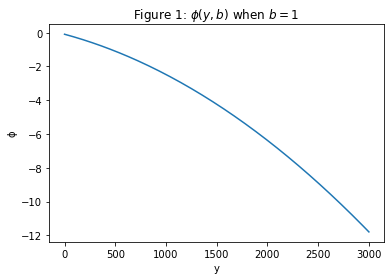

In [56]:
# fig = go.Figure(data=[go.Surface(z=ψ[10,:,:])])

# fig.update_layout(title='Mt Bruno Elevation', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

# fig.show()

plt.figure()
plt.plot(y_grid, ψ[199,:])
plt.title(r'Figure 1: $\phi(y,b)$ when $b=1$ ')
plt.xlabel('y')
plt.ylabel('ϕ')
# plt.savefig('fig_1.pdf')

# plt.figure()
# plt.plot(y_grid, ψ[10,:])
# plt.title(r'Figure 2: $\phi(y,b,z_2)$ when $z_2=1.$, $b=0.01$ ')
# plt.xlabel('y')
# plt.ylabel('ϕ')
# # plt.savefig('fig_2.pdf')

In [57]:
Δ_b = b_grid[1] - b_grid[0]
Δ_y = y_grid[1] - y_grid[0]
(b_mat, y_mat) = np.meshgrid(b_grid, y_grid, indexing = 'ij')
stateSpace = np.hstack([b_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
# v0 = -δ*η*y_mat
v0 = ψ

v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

e = b_mat*δ*η / (1e-4-v0_dy)

Text(0, 0.5, 'e')

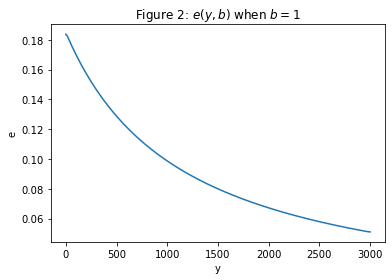

In [58]:
plt.plot(y_grid, e[199,:])
plt.title(r'Figure 2: $e(y,b)$ when $b=1$ ')
plt.xlabel('y')
plt.ylabel('e')
# plt.savefig('fig_2.pdf')